# Reallocation Backtest and Simulation

## Setup

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Project.toml`
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Manifest.toml`
  Activating project at `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23`
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Project.toml`
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Project.toml`
  No Changes to `~/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/Manifest.toml`


## Prerequisites: Load historical dataset, compute expected returns and get 2023 `SPY` data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [4]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-12-01-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [5]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [6]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [7]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### Get the 2023 `SPY` data

In [8]:
startdate = Date(2023,01,03);
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);
SPY_df

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,7.48507e7,380.958,384.37,380.82,386.43,377.831,2023-01-03T05:00:00,590240
2,8.59341e7,383.149,383.18,383.76,385.88,380.0,2023-01-04T05:00:00,632808
3,7.62754e7,380.262,381.72,379.38,381.84,378.76,2023-01-05T05:00:00,530896
4,1.04053e8,385.246,382.61,388.08,389.25,379.413,2023-01-06T05:00:00,687390
5,7.39781e7,390.363,390.37,387.86,393.7,387.67,2023-01-09T05:00:00,549428
6,6.52981e7,389.082,387.25,390.58,390.65,386.27,2023-01-10T05:00:00,471958
7,6.8703e7,393.3,392.23,395.52,395.6,391.38,2023-01-11T05:00:00,452701
8,9.01457e7,396.312,396.67,396.96,398.485,392.42,2023-01-12T05:00:00,665042
9,6.38539e7,396.838,393.62,398.5,399.1,393.34,2023-01-13T05:00:00,468376


### Compute the expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [9]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = 0.0);

## Compute the covariance and expected yield for all firms in the dataset

In [10]:
sims = load(joinpath(_PATH_TO_DATA, "SIMs-TechPortfolio2-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["sims"];

In [11]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

In [12]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
r_SPY = μ[index_SPY]

0.08947352945602301

In [13]:
σₘ = std(all_firms_return_matrix[:, index_SPY])

2.5345018373000348

In [93]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252);

In [94]:
total_initial_budget = 37360842.0; 

In [95]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-TechPortfolio2-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.0468401,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.43448e-7, 0.108249, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05
2,0.0468401,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.43042e-7, 0.108249, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05
3,0.0468401,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.42548e-7, 0.108249, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05
4,0.0468402,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.419e-7, 0.108249, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05
5,0.0468402,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.41005e-7, 0.108249, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05
6,0.0468402,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.39697e-7, 0.108249, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05
7,0.0468402,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.37787e-7, 0.108249, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05
8,0.0468403,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.36127e-7, 0.10825, 0.322252, 0.384941, 0.0828683, 0.101689]",0.05
9,0.0468403,0.202373,"[""AMD"", ""AAPL"", ""MSFT"", ""IBM"", ""ADBE"", ""AMZN""]","[1.38405e-7, 0.10825, 0.322251, 0.384942, 0.0828684, 0.101689]",0.05


In [147]:
portfolio_index = 10;

In [148]:
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
risk = efficient_frontier[portfolio_index,:risk] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)

0.047

In [149]:
tmp_df = DataFrame();
for i ∈ eachindex(w)
    wᵢ = w[i];
    row_df = (
        ticker = my_list_of_tickers[i],
        allocation = wᵢ
    );
    push!(tmp_df, row_df);
end
tmp_df

Row,ticker,allocation
,String,Float64
1,AMD,0.0
2,AAPL,0.108249
3,MSFT,0.322251
4,IBM,0.384942
5,ADBE,0.082868
6,AMZN,0.101689


In [150]:
Sₒ = Array{Float64,1}() # these are close prices at the end of Jan 3, 2023
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close] 
    push!(Sₒ,startprice)
end

In [151]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(w)
    
    wᵢ = w[i]
    nᵢ = (wᵢ*total_initial_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ

6-element Vector{Float64}:
      0.0
  32336.082079299595
  50252.81198489857
 101601.95860942423
   9189.179196414578
  44269.2456553018

In [152]:
number_of_trading_days = 120;

In [153]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

In [154]:
α = 0.01;

In [155]:
# setup the bounds
number_of_firms = length(my_list_of_tickers);
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;

# build an inital problem instance (we'll update in the main simulation loop)
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = w, # let start with the initial optimal allocation 
    R = 0.0
));
     

In [156]:
next_market_day_close_queue = Queue{Vector{Float64}}()
for i ∈ 2:(number_of_trading_days + 1)
    
    price_array = Array{Float64,1}();
    for ticker ∈ my_list_of_tickers
        price_df = dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[i,:close] # get the close price starting *after* Jan 03, 2023
        push!(price_array,startprice)
    end
    
    # add the price array to the queue -
    enqueue!(next_market_day_close_queue, price_array);
end

In [157]:
minimum_desired_return = 2*r_SPY # multiple of expected SPY return

0.17894705891204601

In [158]:
previous_price_array = Sₒ
μ̂_previous = μ̂
N_previous = Nₒ
Δt = (1/252);
my_results_df = DataFrame();
while (isempty(next_market_day_close_queue) == false)
    
    # what was the market vwap
    current_price_array = dequeue!(next_market_day_close_queue); # holds the close price at the end of the trading day
    
    # compute the return -
    asset_return_array = Array{Float64,1}();
    for j ∈ eachindex(my_list_of_tickers)
        tmp = (1/Δt)*log(current_price_array[j]/previous_price_array[j]);
        push!(asset_return_array,tmp);
    end
    
    # update the average return for each asset -
    μ̂_new = μ̂_previous .+ α*(asset_return_array .- μ̂_previous);
    
    # compute new allocation -
    problem_risk_sim.μ = μ̂_new;
    problem_risk_sim.R = minimum_desired_return;
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    w_new = w; # initialize to orginal portfolio -
    risk_new = risk; # initialize to orginal portfolio -
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        w_new = solution_sim["argmax"];
        risk_new = sqrt(solution_sim["objective_value"]);
    end
    
    # liqudation value of the portfolio at the close of trading day i
    liquidation_value_of_porfolio = dot(N_previous, current_price_array);
    
    # compute the number of shares for the new allocation -
    N_new = Array{Float64,1}()
    for i ∈ eachindex(w_new)
        wᵢ = w_new[i]
        nᵢ = (wᵢ*liquidation_value_of_porfolio)/current_price_array[i];
        push!(N_new,nᵢ)
    end
    
    # store data -
    results_tuple = (
        N_new = N_new,
        N_old = N_previous,
        w_old = w,
        w_new = w_new,
        μ_previous = μ̂_previous,
        μ_new = μ̂_new,
        previous_close = previous_price_array,
        current_close = current_price_array,
        liquidation_value_of_porfolio = liquidation_value_of_porfolio,
        risk = risk_new
    );
    push!(my_results_df,results_tuple)
    
    # update values -
    μ̂_previous = μ̂_new;
    previous_price_array = current_price_array;
    N_previous = N_new;
end
my_results_df

Row,N_new,N_old,w_old,w_new,μ_previous,μ_new,previous_close,current_close,liquidation_value_of_porfolio,risk
,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Float64,Float64
1,"[18605.6, 84691.7, 42452.9, 47204.3, 17181.5, 32485.2]","[0.0, 32336.1, 50252.8, 101602.0, 9189.18, 44269.2]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[0.0325201, 0.289283, 0.262909, 0.181959, 0.158566, 0.0747638]","[0.394844, 0.251306, 0.24832, 0.0011949, 0.206192, 0.151402]","[0.415963, 0.274651, 0.13312, 0.019807, 0.237491, 0.129841]","[64.02, 125.07, 239.58, 141.55, 336.92, 85.82]","[64.66, 126.36, 229.1, 142.6, 341.41, 85.14]",3.69937e7,0.203746
2,"[44686.0, 148403.0, 20168.5, 26185.4, 15810.6, 17801.7]","[18605.6, 84691.7, 42452.9, 47204.3, 17181.5, 32485.2]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[0.0769631, 0.512668, 0.123893, 0.102101, 0.143489, 0.0408867]","[0.415963, 0.274651, 0.13312, 0.019807, 0.237491, 0.129841]","[0.319319, 0.245038, 0.0559731, -0.00686059, 0.137517, 0.0680337]","[64.66, 126.36, 229.1, 142.6, 341.41, 85.14]","[62.33, 125.02, 222.31, 141.11, 328.44, 83.12]",3.61898e7,0.222308
3,"[6621.04, 99293.1, 31985.5, 63241.4, 11009.1, 45857.3]","[44686.0, 148403.0, 20168.5, 26185.4, 15810.6, 17801.7]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[0.011388, 0.346101, 0.193469, 0.244382, 0.0985097, 0.10615]","[0.319319, 0.245038, 0.0559731, -0.00686059, 0.137517, 0.0680337]","[0.38118, 0.333644, 0.0849388, 0.0390419, 0.168995, 0.155533]","[62.33, 125.02, 222.31, 141.11, 328.44, 83.12]","[63.96, 129.62, 224.93, 143.7, 332.75, 86.08]",3.71868e7,0.202564
4,"[6498.1, 74979.0, 38648.7, 68597.1, 13016.9, 48191.8]","[6621.04, 99293.1, 31985.5, 63241.4, 11009.1, 45857.3]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[0.0116571, 0.260352, 0.23419, 0.262716, 0.118764, 0.112321]","[0.38118, 0.333644, 0.0849388, 0.0390419, 0.168995, 0.155533]","[0.503395, 0.340591, 0.108506, 0.0360197, 0.236255, 0.191174]","[63.96, 129.62, 224.93, 143.7, 332.75, 86.08]","[67.24, 130.15, 227.12, 143.55, 341.98, 87.36]",3.7482e7,0.1992
5,"[2.93102, 61902.3, 43457.9, 77543.4, 10447.9, 55153.3]","[6498.1, 74979.0, 38648.7, 68597.1, 13016.9, 48191.8]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[5.28198e-6, 0.214305, 0.263371, 0.297346, 0.0937115, 0.131261]","[0.503395, 0.340591, 0.108506, 0.0360197, 0.236255, 0.191174]","[0.528536, 0.34839, 0.126544, 0.057508, 0.209606, 0.260645]","[67.24, 130.15, 227.12, 143.55, 341.98, 87.36]","[68.05, 130.73, 228.85, 144.8, 338.7, 89.87]",3.77616e7,0.196904
6,"[0.0918487, 33817.3, 52777.3, 98228.9, 9777.08, 42294.8]","[2.93102, 61902.3, 43457.9, 77543.4, 10447.9, 55153.3]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[1.64324e-7, 0.116947, 0.322357, 0.369647, 0.0868593, 0.104189]","[0.528536, 0.34839, 0.126544, 0.057508, 0.209606, 0.260645]","[0.560378, 0.397555, 0.200349, 0.0649258, 0.238787, 0.400317]","[68.05, 130.73, 228.85, 144.8, 338.7, 89.87]","[69.06, 133.49, 235.77, 145.26, 342.93, 95.09]",3.8601e7,0.195309
7,"[0.0902075, 34007.4, 52432.9, 98525.3, 9780.24, 42426.7]","[0.0918487, 33817.3, 52777.3, 98228.9, 9777.08, 42294.8]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[1.64628e-7, 0.116947, 0.322357, 0.369647, 0.0868593, 0.104189]","[0.560378, 0.397555, 0.200349, 0.0649258, 0.238787, 0.400317]","[0.61748, 0.392069, 0.227463, 0.0693025, 0.248202, 0.401079]","[69.06, 133.49, 235.77, 145.26, 342.93, 95.09]","[70.8, 133.41, 238.51, 145.55, 344.54, 95.27]",3.87947e7,0.195309
8,"[0.0905376, 33871.9, 52593.8, 98895.0, 9844.43, 41445.5]","[0.0902075, 34007.4, 52432.9, 98525.3, 9780.24, 42426.7]","[0.0, 0.108249, 0.322251, 0.384942, 0.082868, 0.101689]","[1.64693e-7, 0.116947, 0.322357, 0.369647, 0.0868593, 0.104189]","[0.61748, 0.392069, 0.227463, 0.0693025, 0.248202, 0.401079]","[0.618414, 0.41352, 0.232784, 0.0744893, 0.24455, 0.471349]","[70.8, 133.41, 238.51, 145.55, 344.54, 95.27]","[71.0, 134.76, 239.23, 145.

In [159]:
portfolio_performance_array_original = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = Nₒ[i]
    
    for j ∈ 1:number_of_trading_days
        portfolio_performance_array_original[j,i] = nᵢ*ticker_data[j+1,:close];
    end
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_original[i,end] = sum(portfolio_performance_array_original[i,1:end-2])
end

# compute the risk -
for i ∈ 1:number_of_trading_days
    data = portfolio_performance_array_original[i,1:end-2];
    total = portfolio_performance_array_original[i,end];
    w = (1/total)*data;
    portfolio_performance_array_original[i,end-1] = transpose(w)*Σ̂*w |> sqrt
end

In [160]:
orignal_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    orignal_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        orignal_table_data[i,1+j] = portfolio_performance_array_original[i,j];
    end
    orignal_table_data[i,end-1] = portfolio_performance_array_original[i,end-1]
    orignal_table_data[i,end] = portfolio_performance_array_original[i,end]
end

pretty_table(orignal_table_data, header=["index",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬─────┬───────────┬───────────┬───────────┬───────────┬───────────┬─────────────┬───────────┐
│ index │ AMD │      AAPL │      MSFT │       IBM │      ADBE │      AMZN │ risk (sqrt) │ total USD │
├───────┼─────┼───────────┼───────────┼───────────┼───────────┼───────────┼─────────────┼───────────┤
│   1.0 │ 0.0 │ 4.08599e6 │ 1.15129e7 │ 1.44884e7 │ 3.13728e6 │ 3.76908e6 │    0.195366 │ 3.69937e7 │
│   2.0 │ 0.0 │ 4.04266e6 │ 1.11717e7 │ 1.43371e7 │ 3.01809e6 │ 3.67966e6 │    0.195387 │ 3.62492e7 │
│   3.0 │ 0.0 │  4.1914e6 │ 1.13034e7 │ 1.46002e7 │  3.0577e6 │  3.8107e6 │    0.195387 │ 3.69634e7 │
│   4.0 │ 0.0 │ 4.20854e6 │ 1.14134e7 │  1.4585e7 │ 3.14252e6 │ 3.86736e6 │     0.19537 │ 3.72168e7 │
│   5.0 │ 0.0 │  4.2273e6 │ 1.15004e7 │  1.4712e7 │ 3.11237e6 │ 3.97848e6 │    0.195373 │ 3.75305e7 │
│   6.0 │ 0.0 │ 4.31654e6 │ 1.18481e7 │ 1.47587e7 │ 3.15125e6 │ 4.20956e6 │     0.19535 │ 3.82842e7 │
│   7.0 │ 0.0 │ 4.31396e6 │ 1.19858e7 │ 1.47882e7 │ 3.16604e6 │ 4.21753e6 │    0.1

In [161]:
portfolio_performance_array_reallocate = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)

# values for each asset -
for i ∈ 1:(number_of_trading_days)
    
    risk_new = my_results_df[i,:risk]
    N_new = my_results_df[i,:N_new]
    new_price = my_results_df[i,:current_close]
    
    for j ∈ eachindex(my_list_of_tickers)
        portfolio_performance_array_reallocate[i,j] = N_new[j]*new_price[j] |> x-> round(x, digits=3) |> abs
    end
    
    # compute the risk -
    portfolio_performance_array_reallocate[i,end-1] = risk_new
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_reallocate[i,end] = sum(portfolio_performance_array_reallocate[i,1:end-2])
end

# compute the initial risk -
total = portfolio_performance_array_reallocate[1,end];
data = portfolio_performance_array_reallocate[1,1:end-2];
w = (1/total)*data
portfolio_performance_array_reallocate[1,end-1] = transpose(w)*Σ̂*w |> sqrt;

In [162]:
reallocate_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    reallocate_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        reallocate_table_data[i,1+j] = portfolio_performance_array_reallocate[i,j];
    end
    reallocate_table_data[i,end-1] = portfolio_performance_array_reallocate[i,end-1]
    reallocate_table_data[i,end] = portfolio_performance_array_reallocate[i,end]
end

pretty_table(reallocate_table_data, header=["day",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬─────────────┬───────────┐
│   day │       AMD │      AAPL │      MSFT │       IBM │      ADBE │      AMZN │ risk (sqrt) │ total USD │
├───────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼─────────────┼───────────┤
│   1.0 │ 1.20304e6 │ 1.07016e7 │ 9.72596e6 │ 6.73133e6 │ 5.86594e6 │ 2.76579e6 │    0.203746 │ 3.69937e7 │
│   2.0 │ 2.78528e6 │ 1.85533e7 │ 4.48366e6 │ 3.69502e6 │ 5.19284e6 │ 1.47968e6 │    0.222308 │ 3.61898e7 │
│   3.0 │ 4.23482e5 │ 1.28704e7 │ 7.19451e6 │ 9.08779e6 │ 3.66326e6 │ 3.94739e6 │    0.202564 │ 3.71868e7 │
│   4.0 │ 4.36932e5 │ 9.75852e6 │  8.7779e6 │ 9.84711e6 │ 4.45153e6 │ 4.21003e6 │      0.1992 │  3.7482e7 │
│   5.0 │   199.456 │ 8.09249e6 │ 9.94533e6 │ 1.12283e7 │  3.5387e6 │ 4.95663e6 │    0.196904 │ 3.77616e7 │
│   6.0 │     6.343 │ 4.51427e6 │ 1.24433e7 │ 1.42687e7 │ 3.35285e6 │ 4.02181e6 │    0.195309 │  3.8601e7 │
│   7.0 │     6.387 │ 4.5369

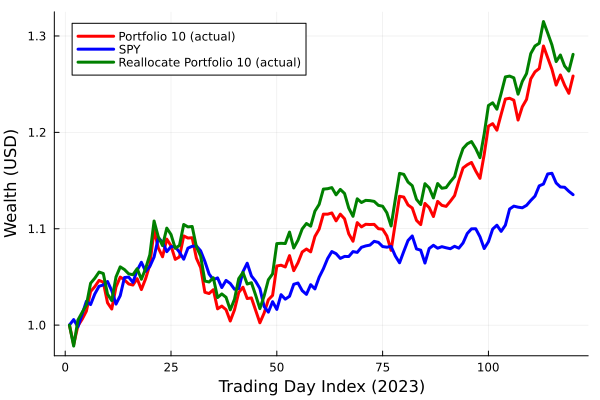

In [164]:
p = plot((1/portfolio_performance_array_original[1,end]).*portfolio_performance_array_original[:,end], 
    lw=3, c=:red, label="Portfolio $(portfolio_index) (actual)")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[1:number_of_trading_days,:volume_weighted_average_price], lw=3, 
    c=:blue, label="SPY")
plot!((1/portfolio_performance_array_reallocate[1,end]).*portfolio_performance_array_reallocate[:,end], lw=3, 
    c=:green, label="Reallocate Portfolio $(portfolio_index) (actual)")
xlabel!("Trading Day Index (2023)", fontsize=18)
ylabel!("Wealth (USD)", fontsize=18)

In [166]:
savefig(p, joinpath(joinpath(pwd(), "figs"), "OnlineReallocation-Portfolio$(portfolio_index)-CHEME-5660-Fall-2023.pdf"))

"/Users/arunabhsarkar/Documents/GitHub/CHEME5660/CHEME-5660-Project-Template-F23/figs/OnlineReallocation-Portfolio10-CHEME-5660-Fall-2023.pdf"